In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('./data/cleaned_wine.csv')

In [4]:
df.head()

,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,wine
0,7.4,0.70,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,red
1,7.8,0.88,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,red
2,7.8,0.76,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,red
3,11.2,0.28,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,red
4,7.4,0.70,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,red


In [5]:
df.value_counts('wine', normalize=True)

wine
white    0.753886
red      0.246114
Name: proportion, dtype: float64

Our baseline is 0.75. We need to beat 0.75 score, as this means we do better than just predicting the mode everytime.

In [6]:
# X = df.drop(columns=['wine', 'fixed acidity', 'volatile acidity', 'sulphates'])
X = df.drop(columns=['wine'])
y = df['wine']
scaler = StandardScaler()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, stratify=y)

In [8]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## KNN

In [9]:
knn = KNeighborsClassifier()

In [10]:
param_grid = {
    'n_neighbors': np.arange(3, 31, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan']
}

In [11]:
grid_knn = GridSearchCV(knn, param_grid, cv=3)

In [12]:
grid_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
                         'weights': ['uniform', 'distance']})

In [13]:
grid_knn.score(X_test_scaled, y_test)

0.9938461538461538

In [14]:
grid_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}

In [15]:
best_knn = grid_knn.best_estimator_

In [16]:
knn_pred = best_knn.predict(X_test_scaled)

In [17]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

         red       0.99      0.99      0.99       400
       white       1.00      1.00      1.00      1225

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



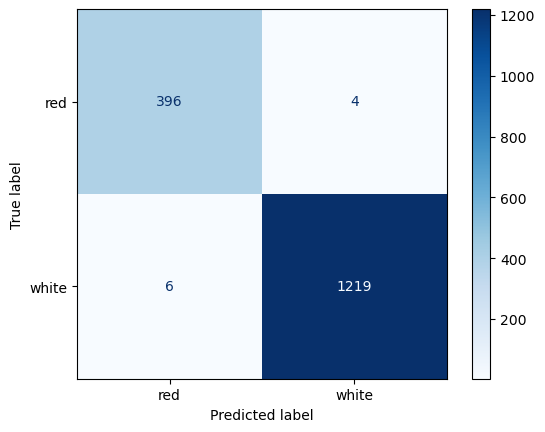

In [18]:
ConfusionMatrixDisplay.from_estimator(best_knn, X_test_scaled, y_test, cmap='Blues')

### KNN Analysis
The KNN algorithim with an n_neighbors of 5 produced an accuracy of 0.9932 (see EDA notebook), meaning it was able to accurately predict the correct wine 99.32% of the time.

However, utilizing grid search, I found that the best performing paramters were an n_neighbors of 11, using weighted distance, and using manhattan distnace formula. This produced an accuracy score of 0.9938, or accurate 99.38% of the time.

This is not much of an increase, but an increase nonetheless. 

Looking at the Confusion Matrix above, we see if only missed 10 wines. It classified 6 white wines as red, and 4 red wines as white. 

## Random Forest

In [19]:
rf = RandomForestClassifier(random_state=42)

In [20]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
rf.score(X_test, y_test)

0.9944615384615385

In [22]:
rf_preds = rf.predict(X_test)

In [23]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

         red       0.99      0.99      0.99       400
       white       1.00      1.00      1.00      1225

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



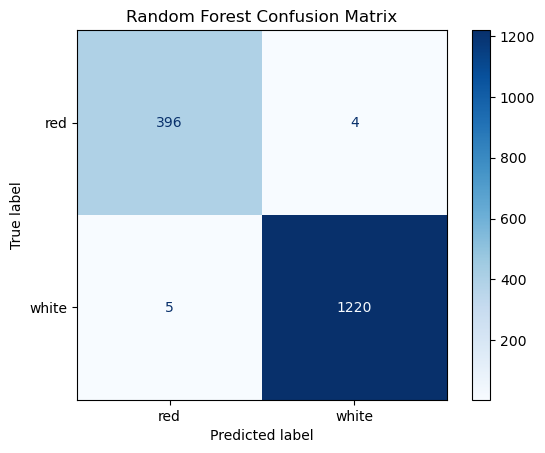

In [39]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.savefig('./images/rf_conf.png')

### Random Forest Analysis
Random Forest performed better than KNN did, get an accuracy score of nearly 100% (0.994). 

In the confusion matrix, we see that it only incorrectly predicted 9 wines.  It classified 5 white wines as red, and 4 red wines as white. 

## Logistic Regression

In [25]:
logreg = LogisticRegression()

In [26]:

logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [27]:

logreg.score(X_test_scaled, y_test)

0.992

In [28]:
log_pred = logreg.predict(X_test_scaled)

In [29]:

print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

         red       0.98      0.98      0.98       400
       white       1.00      0.99      0.99      1225

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



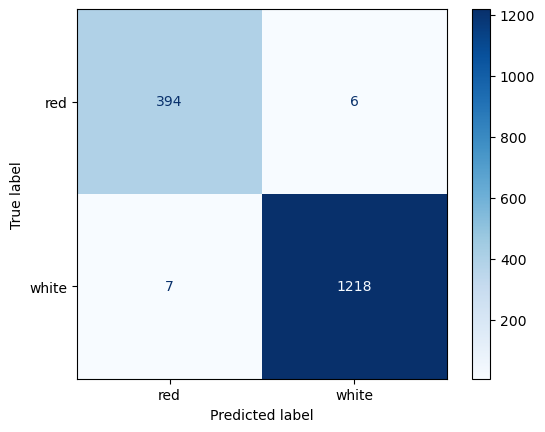

In [30]:

ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test, cmap='Blues')

### Logistic Regression Analysis
Logistic Regression performed slightly worse than the other models did, getting an accuracy score of 0.992, or 99.2%.

In the confusion matrix, we see that it incorrectly predicted 13 wines. It classified 7 white wines as red, and 6 red wines as white.

## Best Model

The best model was Random Forest, as it had the lowest number of false whites and false reds.

Therefore, we will use that model in the flask app. 

In [31]:
import pickle

In [32]:
# with open('model.pkl', 'wb') as file:
#     pickle.dump(rf, file)

In [33]:
# rf.feature_importances_

In [34]:
# X.columns

In [35]:
# imp = pd.DataFrame({'Importance': rf.feature_importances_, 'Features': X.columns})

In [36]:
# sns.barplot(imp, y='Features', x='Importance')

In [37]:
# imp